In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import random
import os
import csv

from Config import Config
from Models import KeypointDetectionModel, ConfidenceModel

/Users/julienstal/Library/Python/3.9/lib/python/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
def split_data(data, test_size=0.2, random_seed=None):
    """
    Split dataset into train and test datasets. In our case, datasets are lists of dictionaries which
    contain entries: "Image Name", "x1", "y1", "x2", "y2"
    
    Parameters:
        data (list of dict): The input data to be split.
        test_size (float): Proportion of the dataset to include in the test split (default is 0.2).
        random_seed (int, optional): Random seed for reproducibility (default is None).
    
    Returns:
        tuple: (train_data, test_data) where both are lists of dictionaries.
    """
    if random_seed is not None:
        random.seed(random_seed)
    
    # Shuffle the data
    shuffled_data = data[:]
    random.shuffle(shuffled_data)
    
    # Compute the split index
    split_idx = int(len(shuffled_data) * (1 - test_size))
    
    # Split the data
    train_data = shuffled_data[:split_idx]
    test_data = shuffled_data[split_idx:]
    
    return train_data, test_data

In [5]:
"""
Create datasets by reading the csv files that contain the coordinates.
"""
with open(Config.coords_file_path, mode='r') as file:
    reader = csv.DictReader(file)  # Use DictReader to automatically map rows to dictionaries
    data = [row for row in reader]  # Convert each row into a dictionary and store in a list

train_data, test_data = split_data(data)
print(f"{len(train_data)} training points and {len(test_data)} test points.")

1919 training points and 480 test points.


In [6]:
# Use "mps" to use GPU on macs ("cuda" on non-mac). "cpu" is slower. 
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Training on device: {device}")

Training on device: mps


In [9]:
"""
Create and train keypoint detection model. 
The KeypointDetection Model (KPD) takes images as inputs and learns to find the two points defining Weber's length.
Note: we keep track and restore the best performing version on the test dataset to avoid overfitting
"""
kpd_model = KeypointDetectionModel.KeypointDetectionModel().to(device)
KeypointDetectionModel.train_kpd_model(kpd_model, train_data, test_data, 50, 480, 801)

Epoch 0: test loss = 0.0704583153128624, lr = 9.900000000000001e-05
Epoch 50: test loss = 0.0043894401751458645, lr = 5.9895600646616125e-05
Epoch 100: test loss = 0.002980334684252739, lr = 3.62372017860497e-05
Epoch 150: test loss = 0.0024073796812444925, lr = 2.1923726936647233e-05
Epoch 200: test loss = 0.0022846765350550413, lr = 1.326398781093821e-05
Epoch 250: test loss = 0.0021610702387988567, lr = 8.024793100055947e-06
Epoch 300: test loss = 0.002125527709722519, lr = 4.855048513057286e-06
Epoch 350: test loss = 0.002110747154802084, lr = 2.9373338066467324e-06
Epoch 400: test loss = 0.0020929600577801466, lr = 1.7771047742294685e-06
Epoch 450: test loss = 0.002087702974677086, lr = 1.0751591703479103e-06
Epoch 500: test loss = 0.002081110142171383, lr = 6.50477821199046e-07
Epoch 550: test loss = 0.002078612335026264, lr = 3.9354302836382843e-07
Epoch 600: test loss = 0.0020795008167624474, lr = 2.3809591983979575e-07
Epoch 650: test loss = 0.002078610472381115, lr = 1.440494

In [11]:
best_kpd_state = kpd_model.state_dict()

In [55]:
"""
Create and train the confidence model (same mechanism as above to avoid overfitting).
The confidence model takes images as inputs and outputs a number estimating the error of the KPD model on the given image.
It learns to estimate how hard an image is for the KPD model (for example unusual body shape, too many legs leading to hidden KeyPoint, ...).
The goal is to be able to predict for which images the KPD model can be trusted.
"""
kpd_model.eval()

# Norm min, max can be used to normalize the errors (default 0, 1 doesn't normalize). Somehow doesn't work at all.
train_error_data, norm_min, norm_max = ConfidenceModel.build_error_data(kpd_model, train_data[:1919], norm_min=0, norm_max = 1)
test_error_data, norm_min_test, norm_max_test = ConfidenceModel.build_error_data(kpd_model, test_data[:480], norm_min=0, norm_max=1)

In [117]:
# Confidence model quite bad for now, barely trains
conf_model = ConfidenceModel.ConfidenceModel().to(device)
ConfidenceModel.train_conf_model_fast(conf_model, train_error_data, test_error_data, 400, 480, 41, feedback_rate=5, initial_lr=1e-6)

Epoch 0: test loss = 8.179194264812395e-05, lr = 9.9e-07
Epoch 5: test loss = 2.9563885618699715e-05, lr = 9.414801494010001e-07
Epoch 10: test loss = 3.0009136025910266e-05, lr = 8.953382542587165e-07
Epoch 15: test loss = 1.78014761331724e-05, lr = 8.514577710948756e-07
Epoch 20: test loss = 2.195394699811004e-05, lr = 8.097278682212586e-07
Epoch 25: test loss = 1.74863453139551e-05, lr = 7.700431458051553e-07
Epoch 30: test loss = 1.761703060765285e-05, lr = 7.323033696543975e-07
Epoch 35: test loss = 1.7375938114128076e-05, lr = 6.964132180495735e-07
Epoch 40: test loss = 1.6515747120138258e-05, lr = 6.622820409839834e-07


Confident predictions:
Error estimation =  0.001294383779168129


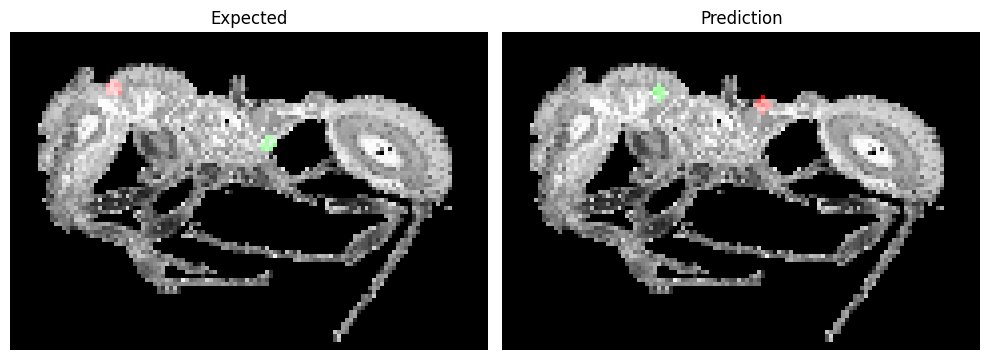

Error estimation =  0.0012872414663434029


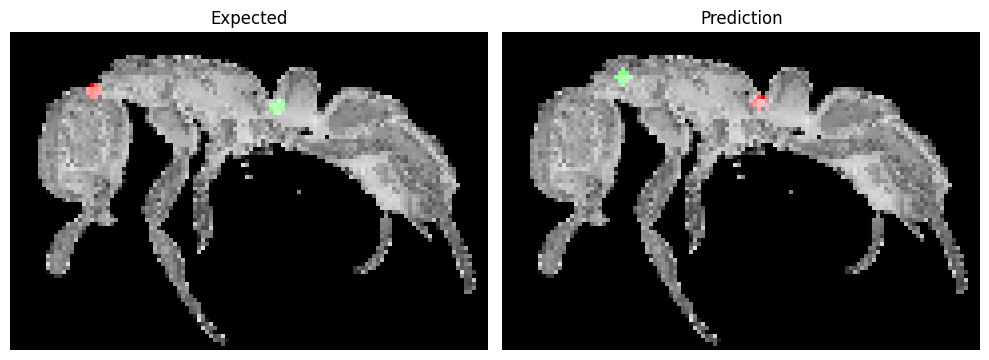

Error estimation =  0.0005176449194550514


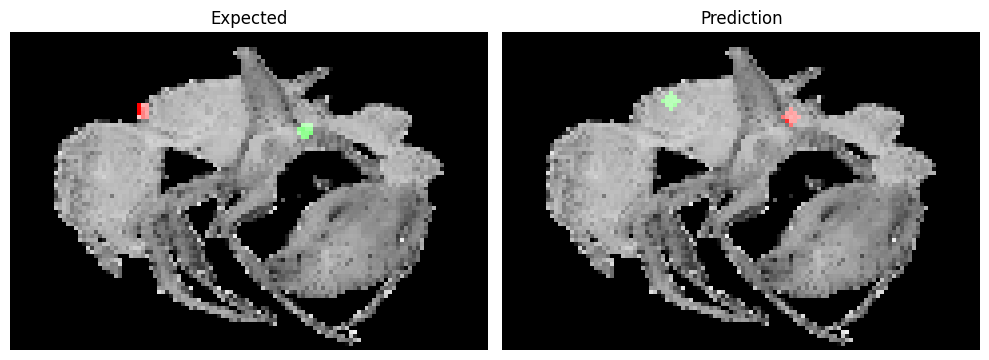

Error estimation =  0.0013535418547689915


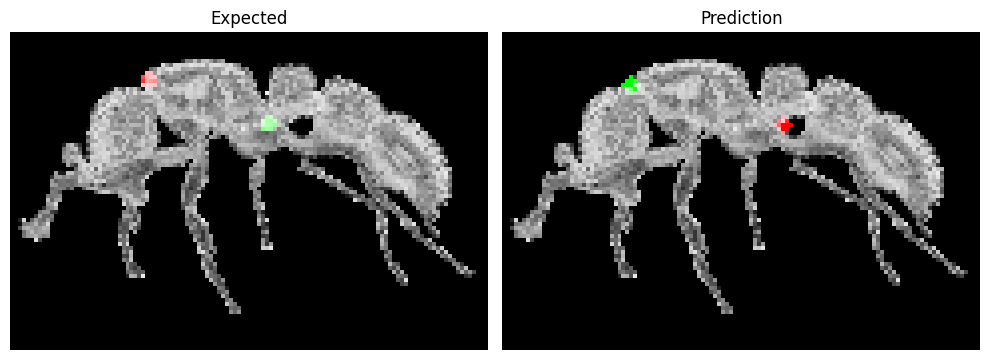

Error estimation =  0.0010471600107848644


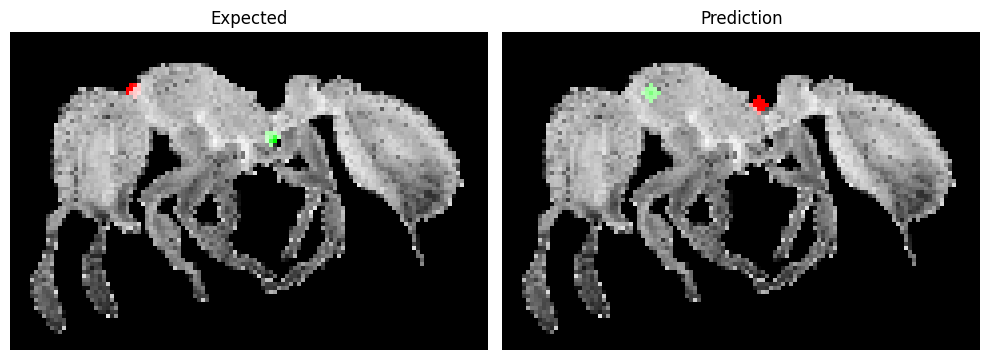

In [118]:
kpd_model.eval()
conf_model.eval()

print("Confident predictions:")
KeypointDetectionModel.plot_model_prediction(kpd_model, test_data, 20, conf_model = conf_model, error_estimation_interval= [0, 0.0015],augment_images=False, device="mps")

Low-confidence predictions:
Error estimation =  0.005331697408109903


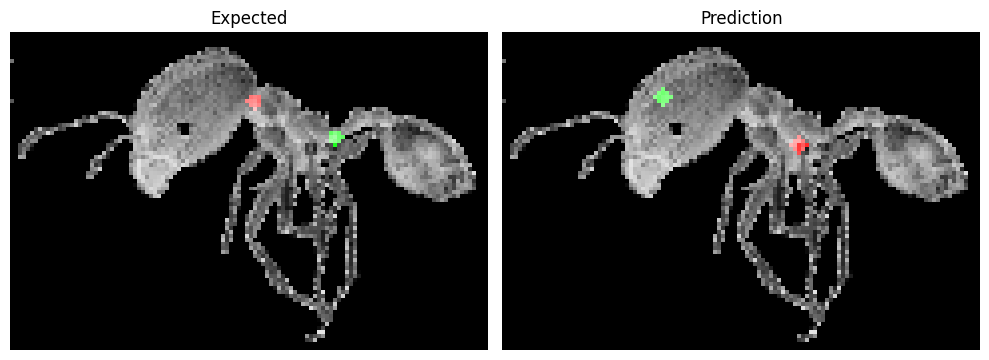

Error estimation =  0.003958478104323149


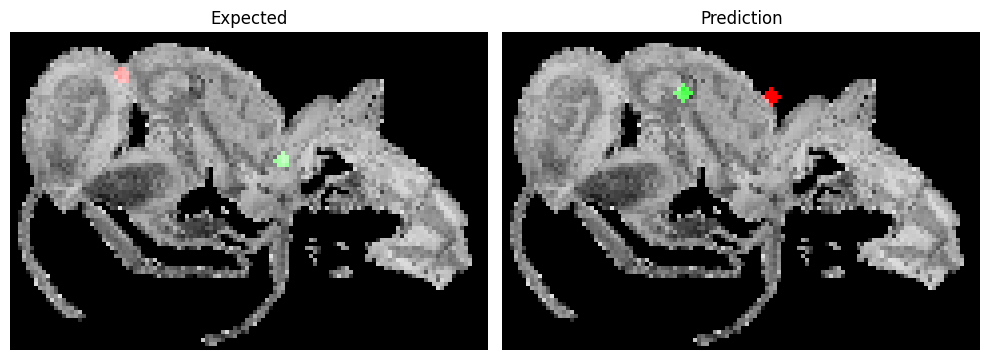

Error estimation =  0.004864400718361139


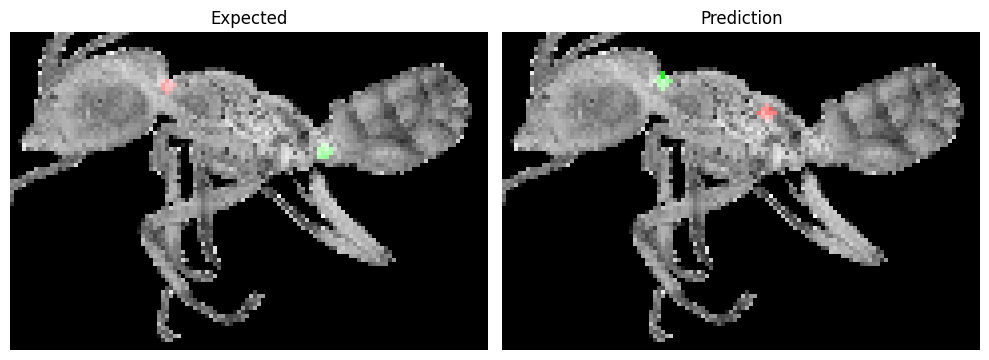

Error estimation =  0.004015652928501368


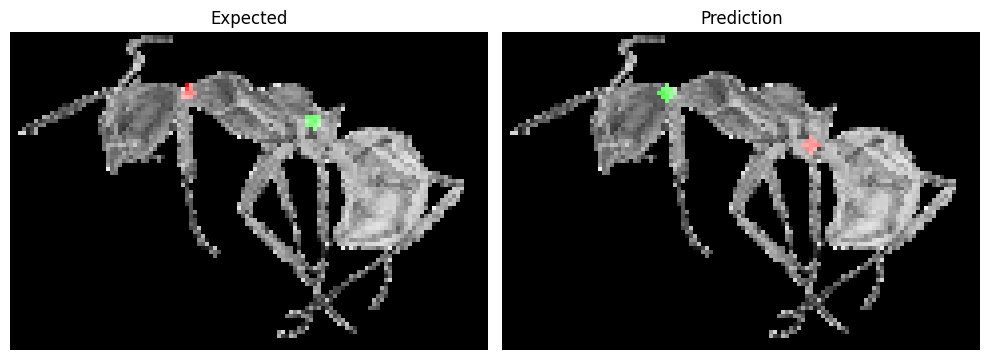

Error estimation =  0.00446899002417922


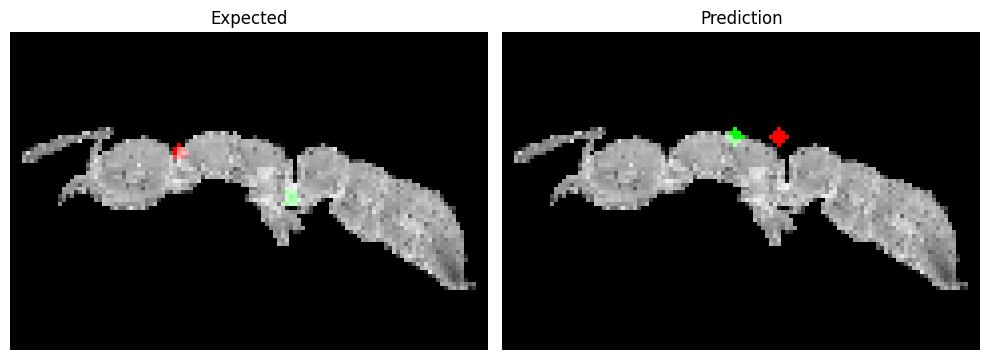

Error estimation =  0.00316281383857131


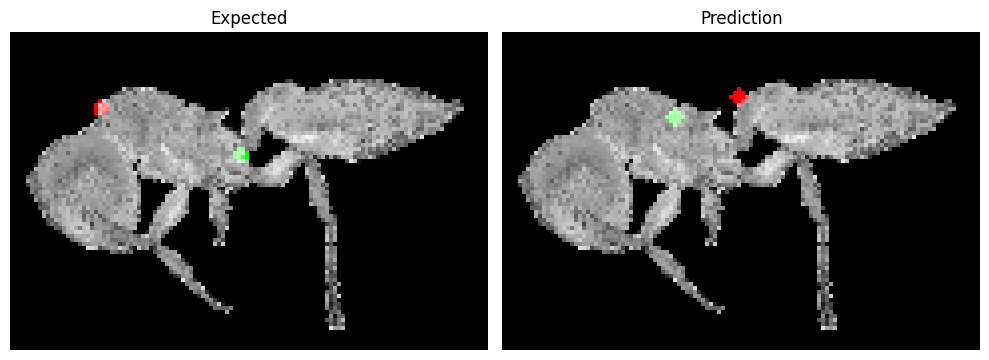

Error estimation =  0.004125439096242189


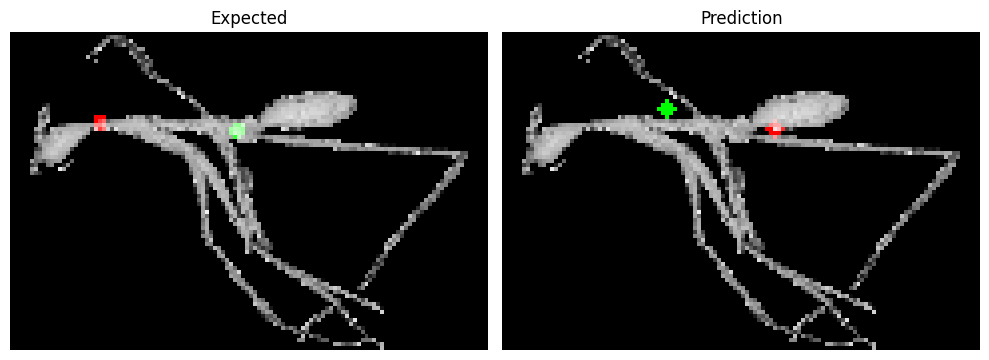

Error estimation =  0.0036243670620024204


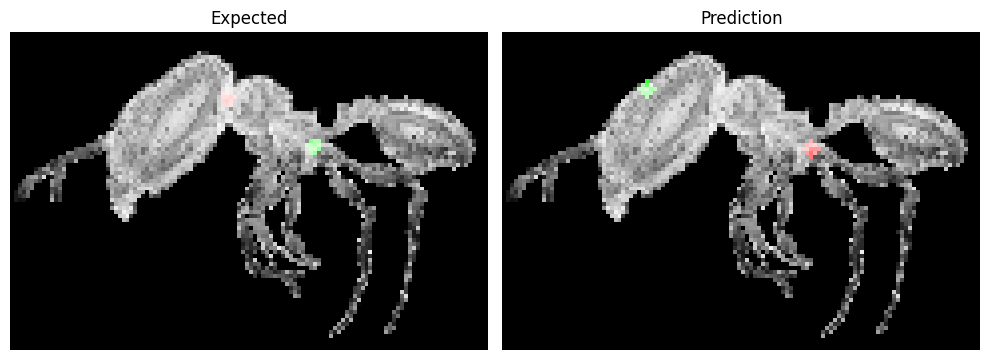

Error estimation =  0.0048093353398144245


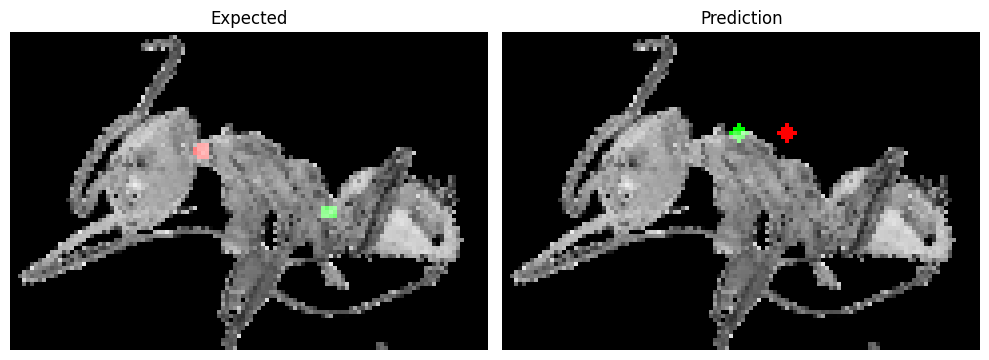

Error estimation =  0.003984577488154173


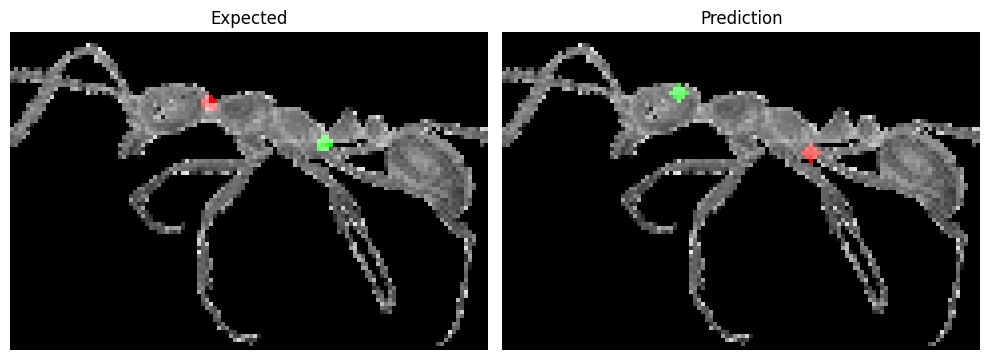

Error estimation =  0.0030625914223492146


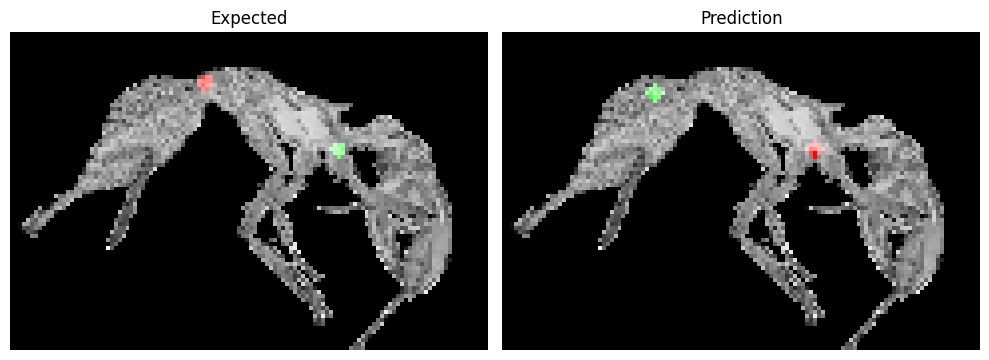

Error estimation =  0.004591829609125853


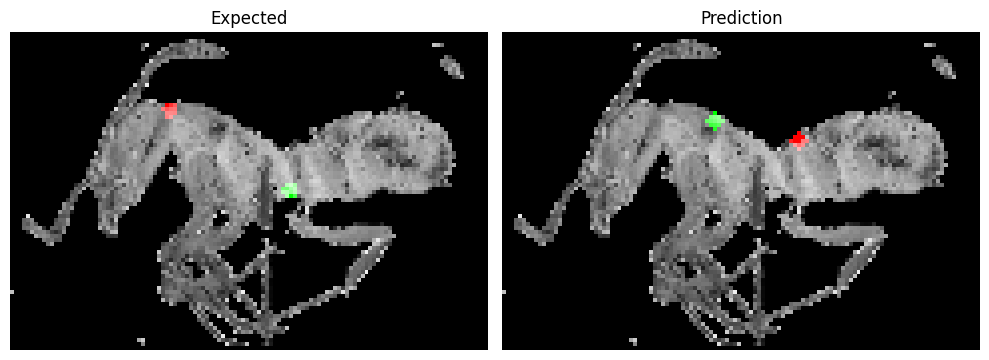

Error estimation =  0.004641268867999315


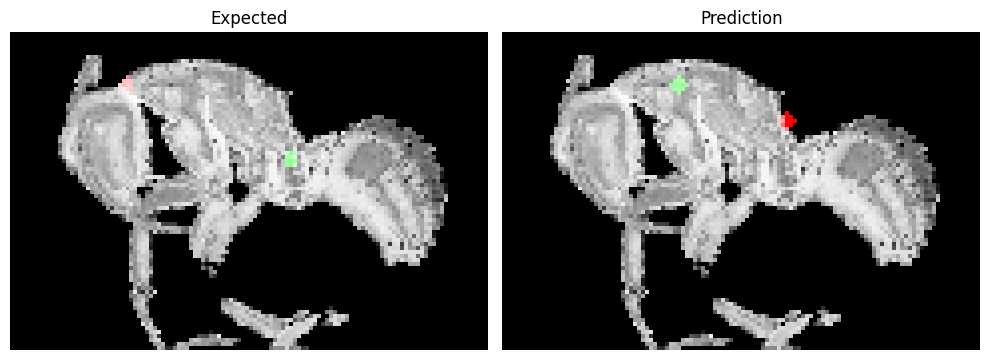

In [119]:
kpd_model.eval()
conf_model.eval()

print("Low-confidence predictions:")
KeypointDetectionModel.plot_model_prediction(kpd_model, test_data, 40, conf_model = conf_model, error_estimation_interval= [0.003, 1],augment_images=False, device="mps")